In [0]:
import torch
import gym
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [0]:
env = gym.make('Blackjack-v0')

A random policy with 0.5 probability of chosing heads and 0.5 probablity of choosing tails.

In [0]:
def gen_random_policy(n_action):
    probs = torch.ones(n_action) / n_action
    def policy_function(state):
        return probs
    return policy_function

In [0]:
gamma = 1
n_episode = 500000
random_policy = gen_random_policy(env.action_space.n)

**Monte-Carlo Off Policy Method**

An episode which is run according to the behavioural policy.

In [0]:
def run_episode(env, behavior_policy):
    """
    Run a episode given a behavior policy
    @param env: OpenAI Gym environment
    @param behavior_policy: behavior policy
    @return: resulting states, actions and rewards for the entire episode
    """
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = behavior_policy(state)
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

Monte carlo off policy control

In [0]:
from collections import defaultdict


def mc_control_off_policy(env, gamma, n_episode, behavior_policy):
    """
    Obtain the optimal policy with off-policy MC control method
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param behavior_policy: behavior policy
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        W = {}
        w = 1.
        states_t, actions_t, rewards_t = run_episode(env, behavior_policy)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            W[(state_t, action_t)] = w
            if action_t != torch.argmax(Q[state_t]).item():
                break
            w *= 1. / behavior_policy(state_t)[action_t]
        for state_action, return_t in G.items():
            state, action = state_action
            if state[0] <= 21:
                G_sum[state_action] += return_t * W[state_action]
                N[state_action] += 1
                Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [28]:
%%time
optimal_Q, optimal_policy = mc_control_off_policy(env, gamma, n_episode, random_policy)

CPU times: user 59.5 s, sys: 8.93 ms, total: 59.5 s
Wall time: 59.5 s


In [29]:
print(optimal_policy)

optimal_value = defaultdict(float)
for state, action_values in optimal_Q.items():
    optimal_value[state] = torch.max(action_values).item()


{(15, 3, False): 0, (15, 9, False): 1, (18, 9, False): 0, (21, 10, False): 0, (21, 10, True): 0, (5, 2, False): 1, (21, 9, False): 0, (18, 6, False): 0, (13, 6, False): 0, (18, 8, False): 0, (7, 2, False): 0, (14, 9, False): 0, (8, 9, False): 0, (19, 4, False): 0, (19, 1, False): 0, (18, 10, False): 0, (13, 10, False): 0, (10, 10, False): 1, (19, 9, False): 0, (17, 9, False): 0, (17, 5, False): 0, (17, 10, False): 0, (20, 8, False): 0, (14, 5, False): 0, (14, 6, False): 0, (15, 5, False): 0, (13, 5, False): 0, (13, 4, False): 1, (9, 4, False): 1, (16, 10, False): 0, (12, 6, False): 0, (17, 2, False): 0, (17, 10, True): 0, (14, 10, True): 0, (13, 10, True): 0, (15, 2, False): 0, (21, 8, True): 0, (17, 6, True): 0, (17, 7, False): 0, (14, 3, False): 0, (9, 2, False): 1, (14, 1, False): 0, (18, 3, False): 0, (20, 10, False): 0, (19, 2, False): 0, (20, 7, False): 0, (13, 8, False): 1, (19, 7, False): 0, (15, 8, False): 1, (9, 8, False): 1, (13, 2, False): 0, (10, 3, False): 1, (12, 2, Fals

**Evaluating MC-Control Off polciy method**

In [30]:
hold_score = 18

hold_policy = {}
player_sum_range = range(2, 22)
for player in range(2, 22):
    for dealer in range(1, 11):
        action = 1 if player < hold_score else 0
        hold_policy[(player, dealer, False)] = action
        hold_policy[(player, dealer, True)] = action



def simulate_episode(env, policy):
    state = env.reset()
    is_done = False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward



n_episode = 100000
n_win_optimal = 0
n_win_simple = 0
n_lose_optimal = 0
n_lose_simple = 0

for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
    reward = simulate_episode(env, hold_policy)
    if reward == 1:
        n_win_simple += 1
    elif reward == -1:
        n_lose_simple += 1



print('Winning probability under the simple policy: {}'.format(n_win_simple/n_episode))
print('Winning probability under the optimal policy: {}'.format(n_win_optimal/n_episode))

print('Losing probability under the simple policy: {}'.format(n_lose_simple/n_episode))
print('Losing probability under the optimal policy: {}'.format(n_lose_optimal/n_episode))

Winning probability under the simple policy: 0.39855
Winning probability under the optimal policy: 0.4105
Losing probability under the simple policy: 0.50981
Losing probability under the optimal policy: 0.51927


**Plotting function**

In [0]:
def plot_surface(X, Y, Z, title):
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Player Sum')
    ax.set_ylabel('Dealer Showing')
    ax.set_zlabel('Value')
    ax.set_title(title)
    ax.view_init(ax.elev, -120)
    fig.colorbar(surf)
    plt.show()


def plot_blackjack_value(V):
    player_sum_range = range(12, 22)
    dealer_show_range = range(1, 11)
    X, Y = torch.meshgrid([torch.tensor(player_sum_range), torch.tensor(dealer_show_range)])
    values_to_plot = torch.zeros((len(player_sum_range), len(dealer_show_range), 2))
    for i, player in enumerate(player_sum_range):
        for j, dealer in enumerate(dealer_show_range):
            for k, ace in enumerate([False, True]):
                values_to_plot[i, j, k] = V[(player, dealer, ace)]
    plot_surface(X, Y, values_to_plot[:,:,0].numpy(), "Blackjack Value Function Without Usable Ace")
    plot_surface(X, Y, values_to_plot[:,:,1].numpy(), "Blackjack Value Function With Usable Ace")

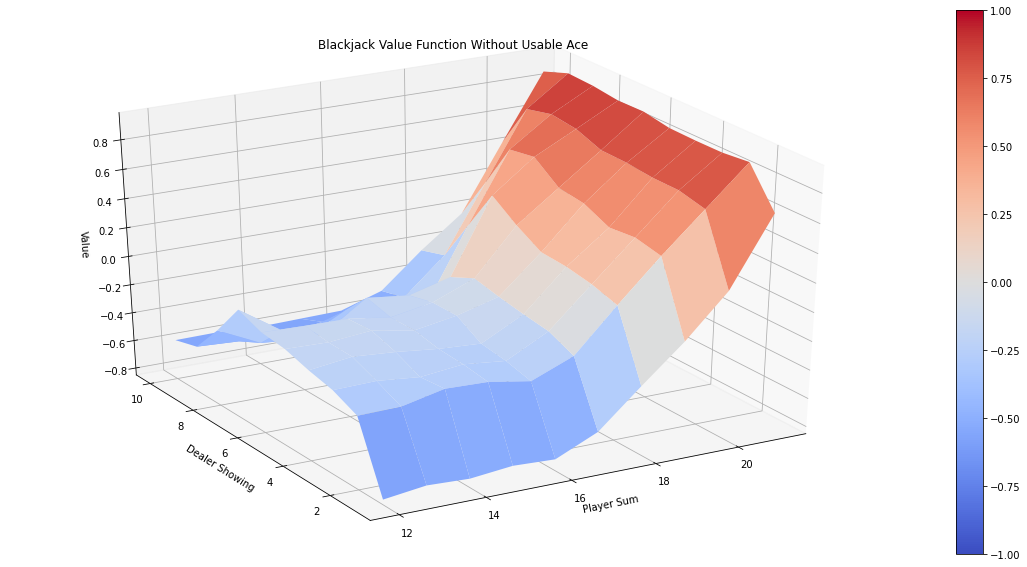

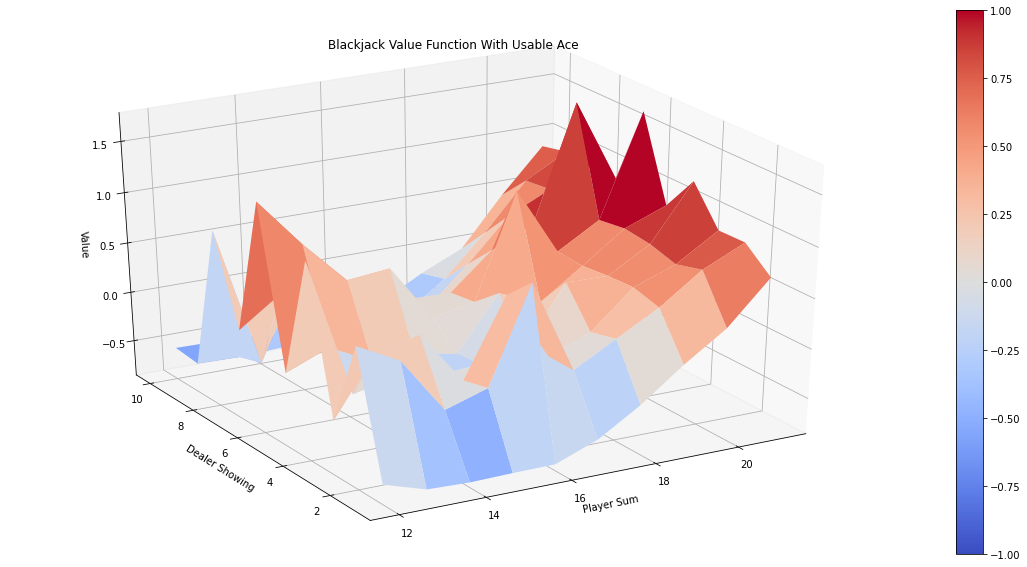

In [32]:
plot_blackjack_value(optimal_value)

We can observe that there is a lot of variance in value function with usable ace.

**Using Monte Carlo Off-Policy Incremental method to perform updates faster**

In [0]:
def mc_control_off_policy_incremental(env, gamma, n_episode, behavior_policy):
    n_action = env.action_space.n
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        W = 1.
        states_t, actions_t, rewards_t = run_episode(env, behavior_policy)
        return_t = 0.
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            N[(state_t, action_t)] += 1
            Q[state_t][action_t] += (W / N[(state_t, action_t)]) * (return_t - Q[state_t][action_t])
            if action_t != torch.argmax(Q[state_t]).item():
                break
            W *= 1./ behavior_policy(state_t)[action_t]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [34]:
%%time
optimal_Q, optimal_policy = mc_control_off_policy_incremental(env, gamma, n_episode, random_policy)

CPU times: user 14 s, sys: 1.98 ms, total: 14 s
Wall time: 14 s


We can clearly observe that the time taken to perform the updates is considerably reduced.

In [0]:
optimal_value = defaultdict(float)
for state, action_values in optimal_Q.items():
    optimal_value[state] = torch.max(action_values).item()


{(20, 5, False): 0, (20, 10, False): 0, (17, 3, False): 0, (17, 4, False): 0, (14, 10, False): 1, (9, 3, False): 1, (7, 3, False): 1, (18, 10, False): 0, (11, 1, False): 1, (21, 1, True): 0, (12, 10, False): 1, (8, 10, False): 1, (18, 1, False): 0, (17, 6, False): 0, (14, 4, False): 1, (17, 10, False): 0, (17, 9, False): 0, (18, 5, True): 0, (12, 5, True): 1, (11, 10, False): 1, (16, 9, False): 1, (5, 4, False): 0, (15, 3, False): 0, (15, 10, False): 0, (14, 7, False): 1, (16, 10, False): 1, (21, 10, False): 0, (13, 1, False): 1, (13, 10, False): 1, (15, 8, False): 1, (12, 2, False): 1, (16, 4, False): 0, (10, 6, False): 1, (15, 1, False): 1, (18, 10, True): 1, (19, 7, False): 0, (19, 1, False): 0, (14, 9, False): 1, (19, 10, False): 0, (15, 7, False): 1, (16, 5, False): 0, (20, 1, False): 0, (13, 7, False): 1, (13, 3, False): 1, (20, 3, False): 0, (17, 5, False): 0, (16, 1, False): 1, (6, 5, False): 1, (19, 9, False): 0, (11, 6, False): 1, (18, 7, False): 0, (15, 2, False): 0, (19, 8,


**Monte Carlo Off Policy method with weighted importance sampling**

In [0]:
def mc_control_off_policy_weighted(env, gamma, n_episode, behavior_policy):
    """
    Obtain the optimal policy with off-policy MC control method with weighted importance sampling
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param behavior_policy: behavior policy
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    N = defaultdict(float)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        W = 1.
        states_t, actions_t, rewards_t = run_episode(env, behavior_policy)
        return_t = 0.
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            N[(state_t, action_t)] += W
            Q[state_t][action_t] += (W / N[(state_t, action_t)]) * (return_t - Q[state_t][action_t])
            if action_t != torch.argmax(Q[state_t]).item():
                break
            W *= 1./ behavior_policy(state_t)[action_t]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [37]:
%%time
optimal_Q, optimal_policy = mc_control_off_policy_weighted(env, gamma, n_episode, random_policy)

CPU times: user 14.2 s, sys: 1.98 ms, total: 14.2 s
Wall time: 14.2 s


In [0]:
optimal_value = defaultdict(float)
for state, action_values in optimal_Q.items():
    optimal_value[state] = torch.max(action_values).item()

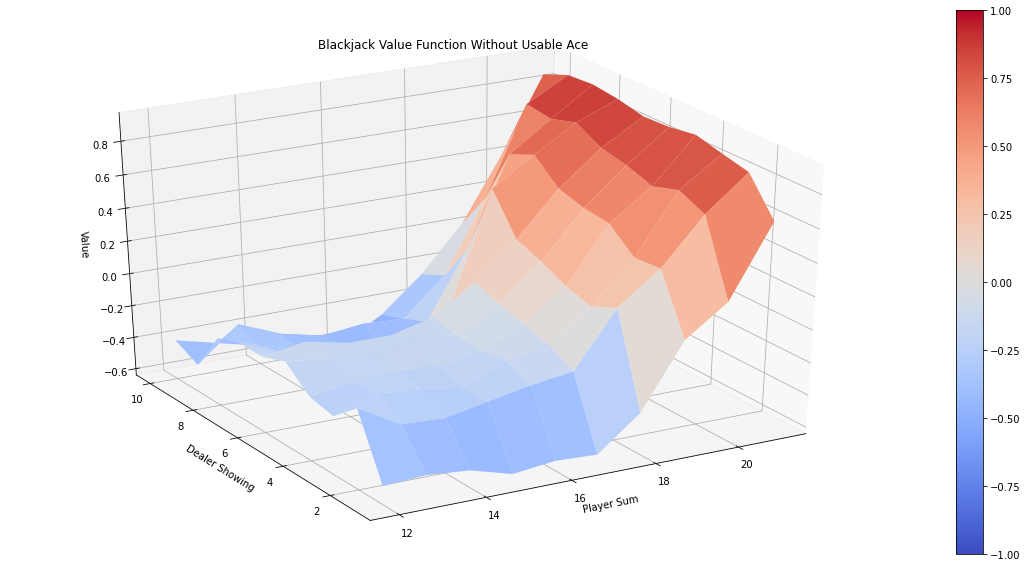

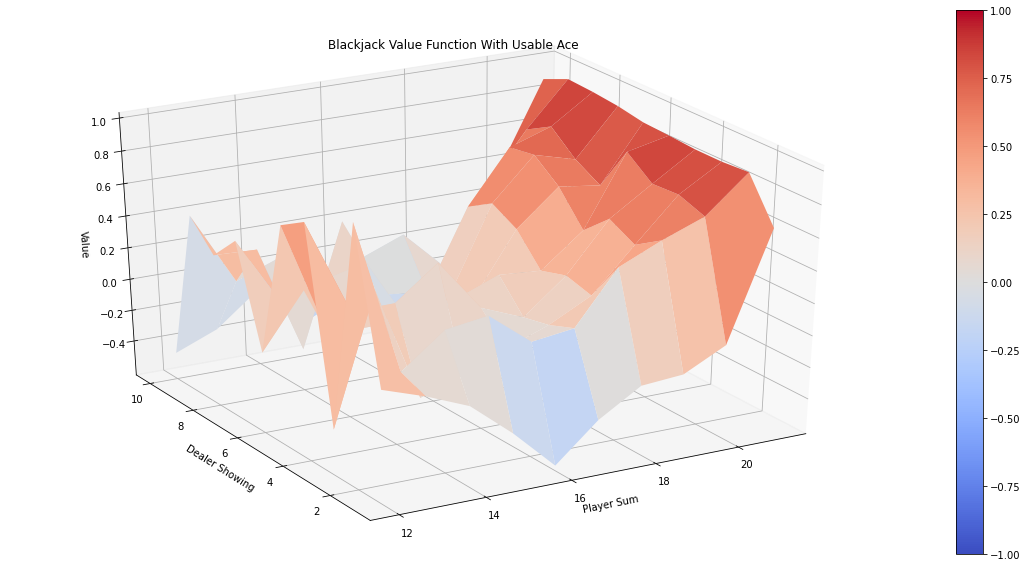

In [39]:
plot_blackjack_value(optimal_value)

We can observe that there is less variance in the usable ace garph when compared to ordinary importance sampling.

In [40]:
n_episode = 100000
n_win_optimal = 0
n_win_simple = 0
n_lose_optimal = 0
n_lose_simple = 0

for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
    reward = simulate_episode(env, hold_policy)
    if reward == 1:
        n_win_simple += 1
    elif reward == -1:
        n_lose_simple += 1



print('Winning probability under the simple policy: {}'.format(n_win_simple/n_episode))
print('Winning probability under the optimal policy: {}'.format(n_win_optimal/n_episode))

print('Losing probability under the simple policy: {}'.format(n_lose_simple/n_episode))
print('Losing probability under the optimal policy: {}'.format(n_lose_optimal/n_episode))

Winning probability under the simple policy: 0.39716
Winning probability under the optimal policy: 0.42766
Losing probability under the simple policy: 0.51178
Losing probability under the optimal policy: 0.47791


**Monte Carlo Control On Policy Method**

In [0]:
# A sample episode for monte carlo policy evalution
def run_episode(env, Q, n_action):
    """
    Run a episode given a Q-function
    @param env: OpenAI Gym environment
    @param Q: Q-function
    @param n_action: action space
    @return: resulting states, actions and rewards for the entire episode
    """
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    action = torch.randint(0, n_action, [1]).item()
    while not is_done:
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        if is_done:
            break
        action = torch.argmax(Q[state]).item()
    return states, actions, rewards

def mc_control_on_policy(env, gamma, n_episode):
    """
    Obtain the optimal policy with on-policy MC control method
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        states_t, actions_t, rewards_t = run_episode(env, Q, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
        for state_action, return_t in G.items():
            state, action = state_action
            if state[0] <= 21:
                G_sum[state_action] += return_t
                N[state_action] += 1
                Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [0]:
gamma = 1
n_episode = 500000

In [43]:
%%time 
optimal_Q, optimal_policy = mc_control_on_policy(env, gamma, n_episode)

CPU times: user 39.4 s, sys: 8.94 ms, total: 39.4 s
Wall time: 39.5 s


In [0]:
optimal_value = defaultdict(float)
for state, action_values in optimal_Q.items():
    optimal_value[state] = torch.max(action_values).item()

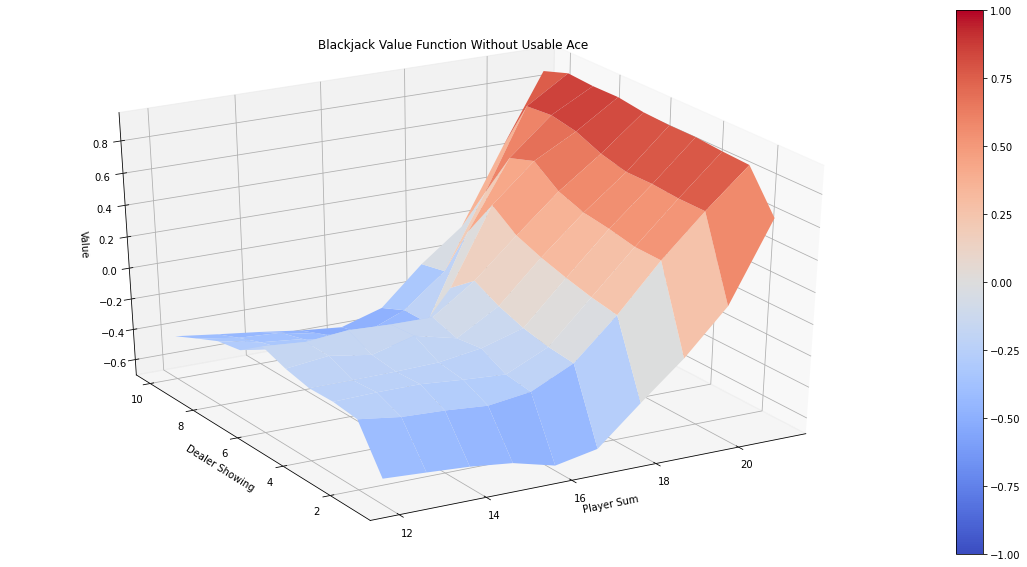

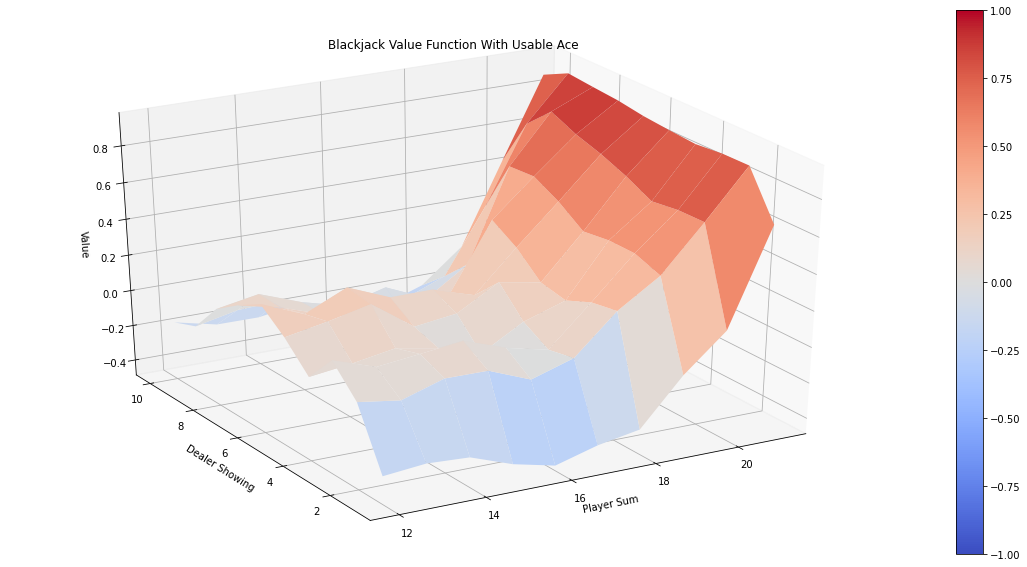

In [45]:
plot_blackjack_value(optimal_value)

**Evaluation of the algorithm**

In [46]:
n_episode = 100000
n_win_optimal = 0
n_win_simple = 0
n_lose_optimal = 0
n_lose_simple = 0

for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
    reward = simulate_episode(env, hold_policy)
    if reward == 1:
        n_win_simple += 1
    elif reward == -1:
        n_lose_simple += 1



print('Winning probability under the simple policy: {}'.format(n_win_simple/n_episode))
print('Winning probability under the optimal policy: {}'.format(n_win_optimal/n_episode))

print('Losing probability under the simple policy: {}'.format(n_lose_simple/n_episode))
print('Losing probability under the optimal policy: {}'.format(n_lose_optimal/n_episode))

Winning probability under the simple policy: 0.40043
Winning probability under the optimal policy: 0.42978
Losing probability under the simple policy: 0.50921
Losing probability under the optimal policy: 0.47793


**Monte Control On Policy Epsilon Greedy Algorithm**

In [0]:
def run_episode(env, Q, epsilon, n_action):
    """
    Run a episode and performs epsilon-greedy policy
    @param env: OpenAI Gym environment
    @param Q: Q-function
    @param epsilon: the trade-off between exploration and exploitation
    @param n_action: action space
    @return: resulting states, actions and rewards for the entire episode
    """
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

In [0]:
def mc_control_epsilon_greedy(env, gamma, n_episode, epsilon):
    """
    Obtain the optimal policy with on-policy MC control with epsilon_greedy
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param epsilon: the trade-off between exploration and exploitation
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
        for state_action, return_t in G.items():
            state, action = state_action
            if state[0] <= 21:
                G_sum[state_action] += return_t
                N[state_action] += 1
                Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

In [50]:
%%time
gamma = 1

n_episode = 500000
epsilon = 0.1

optimal_Q, optimal_policy = mc_control_epsilon_greedy(env, gamma, n_episode, epsilon)

CPU times: user 1min 24s, sys: 15.9 ms, total: 1min 24s
Wall time: 1min 24s


**Evaluation of the algorithm**

In [51]:
n_episode = 100000
n_win_optimal = 0
n_lose_optimal = 0

for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1



print('Winning probability under the optimal policy: {}'.format(n_win_optimal/n_episode))

print('Losing probability under the optimal policy: {}'.format(n_lose_optimal/n_episode))

Winning probability under the optimal policy: 0.42676
Losing probability under the optimal policy: 0.48083


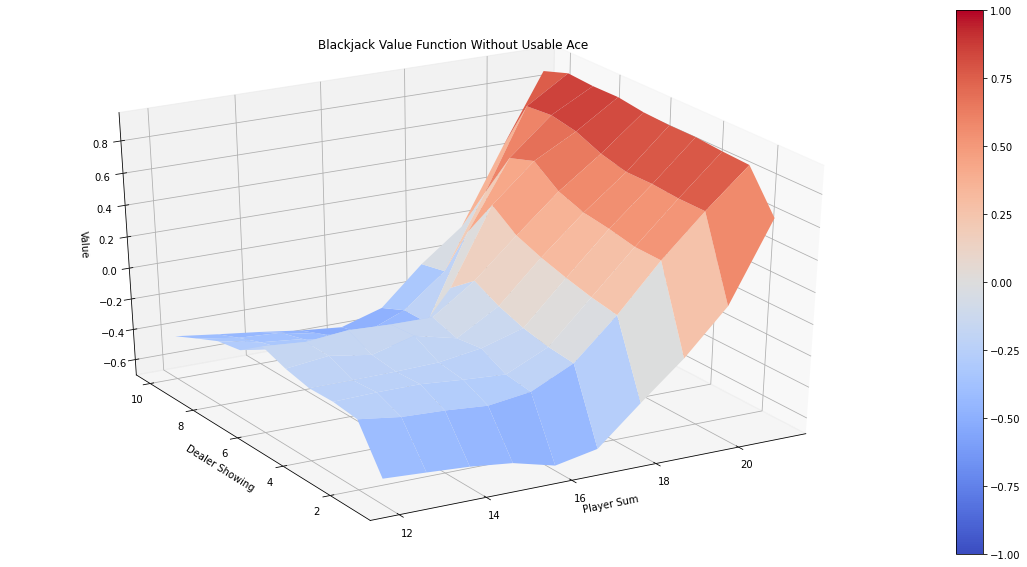

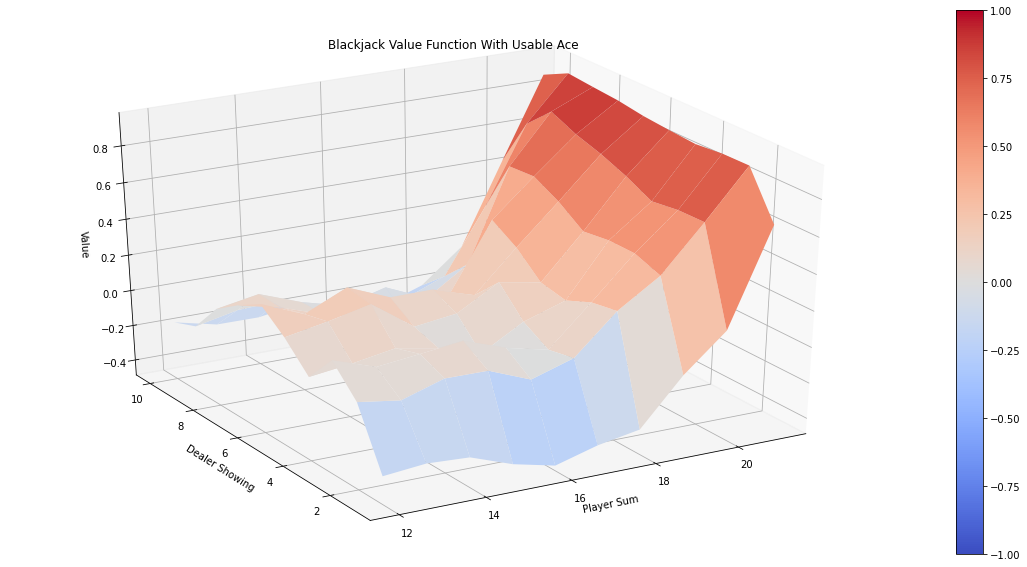

In [52]:
plot_blackjack_value(optimal_value)

**Conclusion**  
We can conclude that Monte Carlo Online Methods have value fucntions smoother than the value functions of the Monte Carlo Offline Methods.
The time taken by Monte-Carlo Online Epislon to find the near optimal policy is more when compared to all the other algorithms.
All alogorithms find the optimal policy of the game

**Temporal difference learning**

In [0]:
def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

**SARSA (Temporal Difference control)**

In [0]:
import random
import numpy as np
import  sys
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    return new_value

def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

In [0]:
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
   
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             # initialize score
        state = env.reset()                                   # start episode
        
        eps = max(1.0 / i_episode, epsmin)                                 # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward                                   # add reward to agent's score
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                break
                
    return Q

Episode 500000/500000

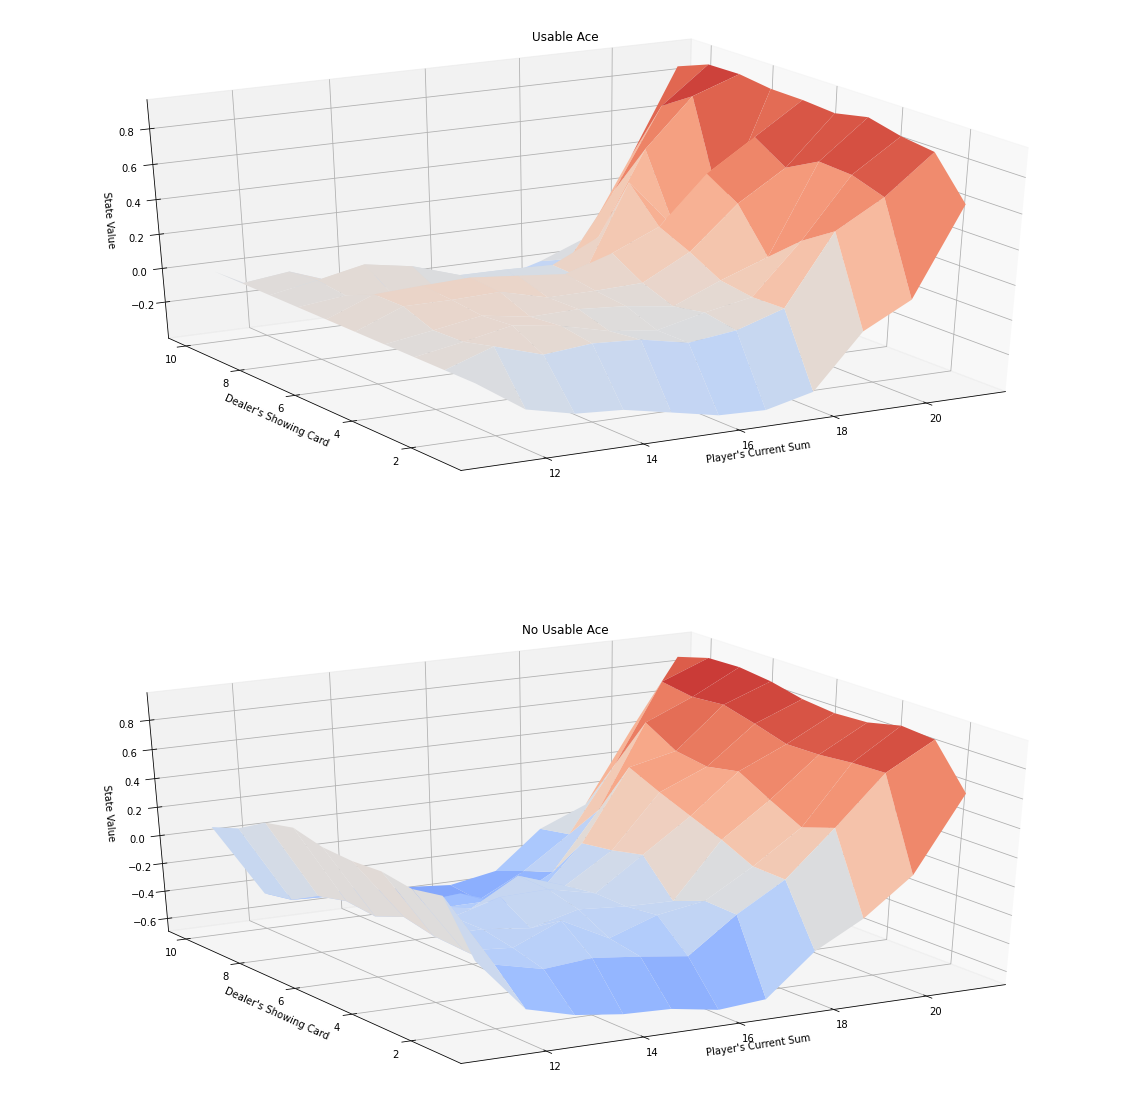

In [68]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 500000, 0.009)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_sarsa.items())

# plot the state-value function
plot_blackjack_values(V)

**Q-learning or Sarsamax**

In [0]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0  # value of next state 
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [0]:
def q_learning(env, num_episodes, alpha, gamma=1.0,epsmin=0.01):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode
        eps = max(1.0 / i_episode ,epsmin)                                 # set value of epsilon
        
                
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                                 state, action, reward, next_state)        
            state = next_state                                 # S <- S'
            # note: no A <- A'
            if done:
                break
    return Q

Episode 500000/500000

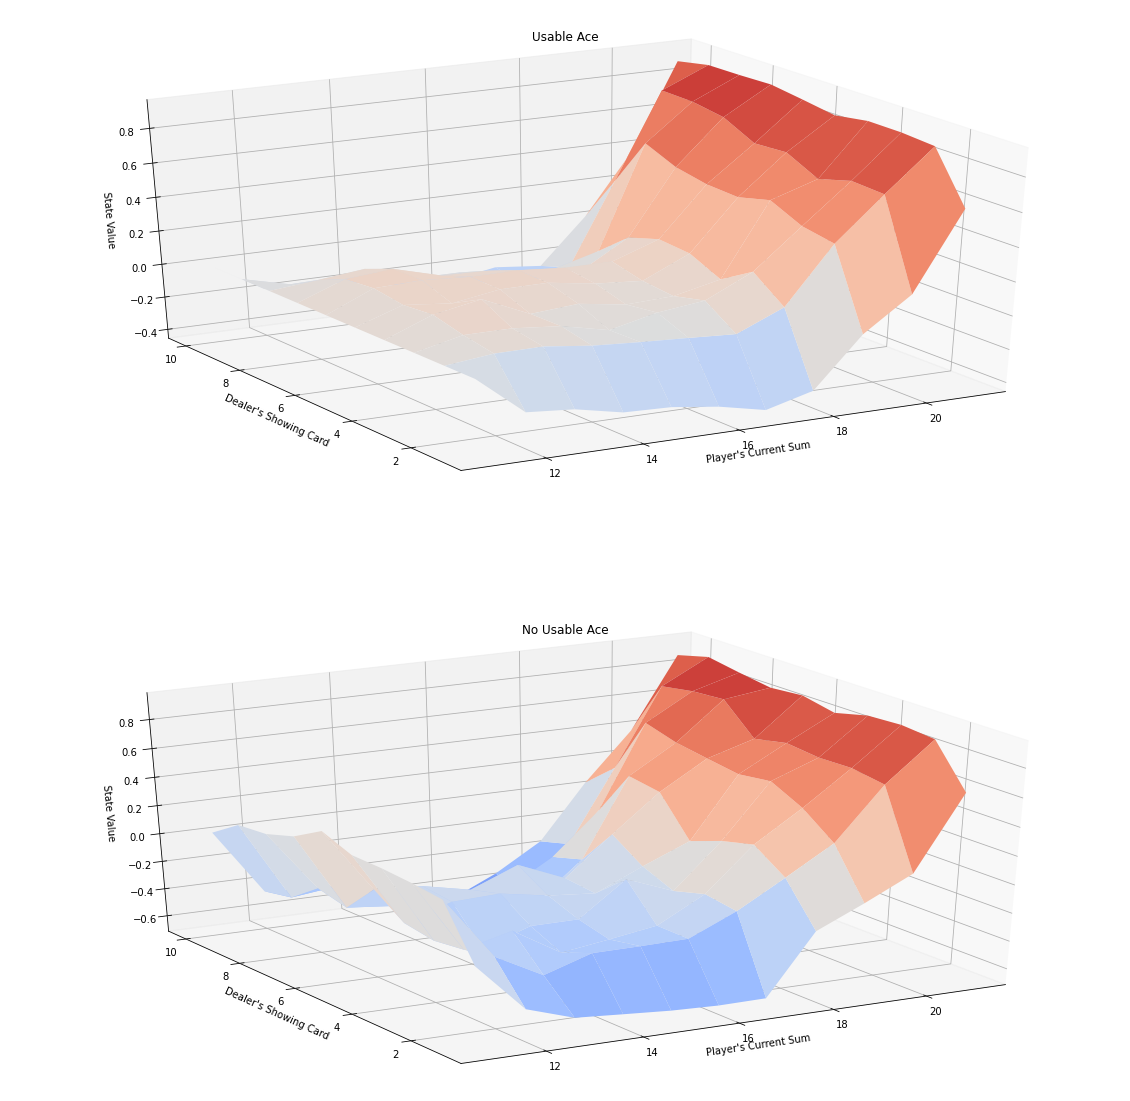

In [72]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = sarsa(env, 500000, 0.01)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_sarsamax.items())

# plot the state-value function
plot_blackjack_values(V)

**Expected Sarsa**

In [0]:
def update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]         # estimate in Q-table (for current state, action pair)
    policy_s = np.ones(nA) * eps / nA  # current policy (for next state S')
    policy_s[np.argmax(Q[next_state])] = 1 - eps + (eps / nA) # greedy action
    Qsa_next = np.dot(Q[next_state], policy_s)         # get value of state at next time step
    target = reward + (gamma * Qsa_next)               # construct target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [0]:
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
   
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             # initialize score
        state = env.reset()                                   # start episode
        
        eps = max(1.0 / i_episode, epsmin)                                 # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            # update Q
            Q[state][action] = update_Q_expsarsa(alpha, gamma, nA, eps, Q, \
                                                 state, action, reward, next_state)        
            state = next_state                           # S <- S'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                break
                
    return Q

Episode 500000/500000

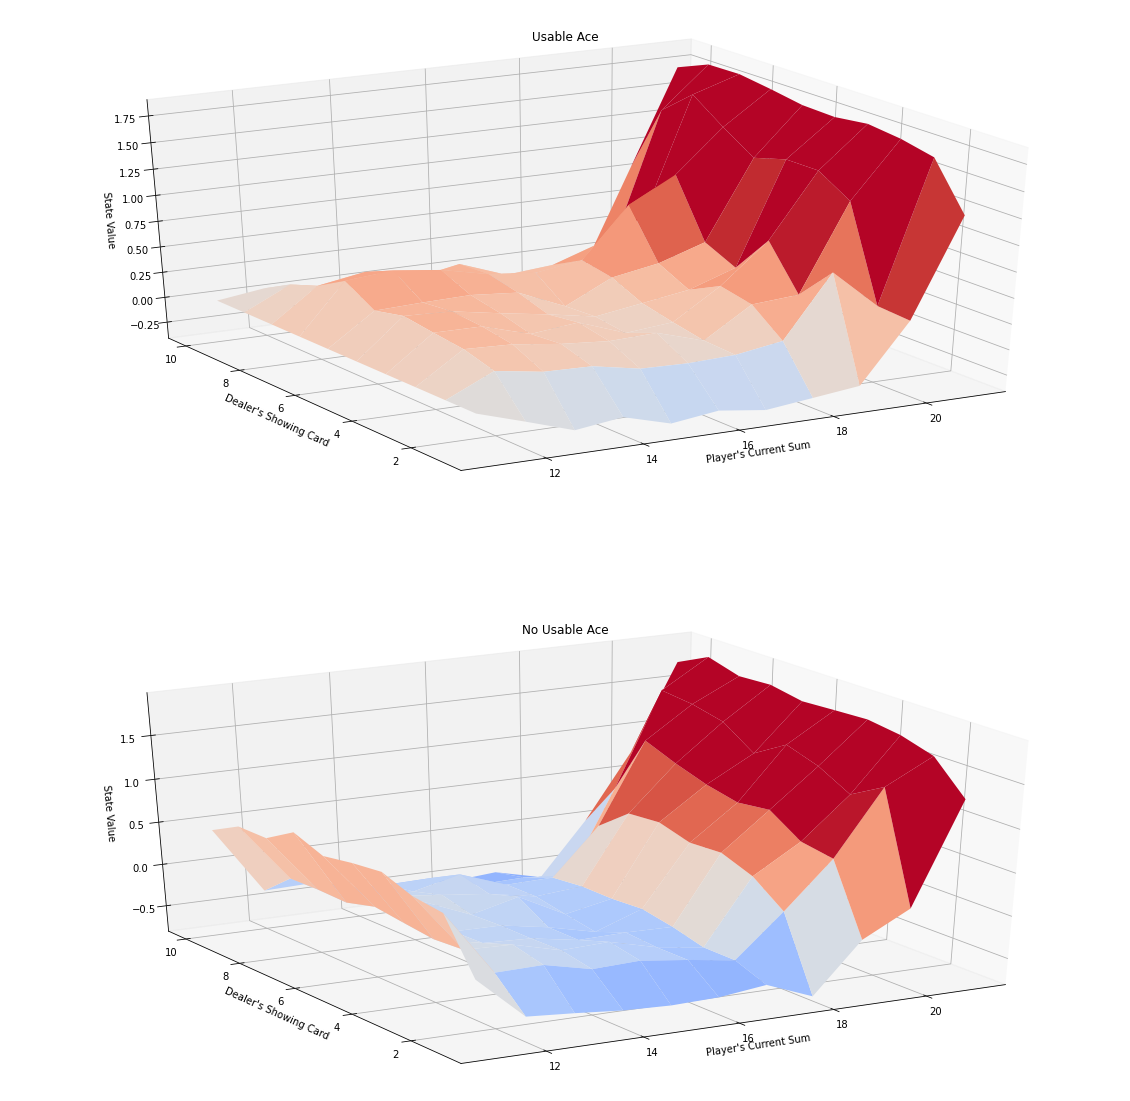

In [75]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = sarsa(env, 500000, 0.01)

# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q_expsarsa.items())

# plot the state-value function
plot_blackjack_values(V)

Since there is a small state space and the episodes are smaller, we do not see much variance in the
results given by the 3 methods as expected. In all 3, the agent seems to develop all techniques in
basic strategy within its state-action space, which ends up giving it a small advantage with respect to
the dealer. With this, we can conclude that the agent has learnt the game to a sufficient level at
which an experienced human can play